Epoch [50/1500], Loss: 0.0997
Epoch [100/1500], Loss: 0.0820
Epoch [150/1500], Loss: 0.0675
Epoch [200/1500], Loss: 0.0560
Epoch [250/1500], Loss: 0.0476
Epoch [300/1500], Loss: 0.0416
Epoch [350/1500], Loss: 0.0373
Epoch [400/1500], Loss: 0.0342
Epoch [450/1500], Loss: 0.0317
Epoch [500/1500], Loss: 0.0298
Epoch [550/1500], Loss: 0.0282
Epoch [600/1500], Loss: 0.0269
Epoch [650/1500], Loss: 0.0258
Epoch [700/1500], Loss: 0.0248
Epoch [750/1500], Loss: 0.0240
Epoch [800/1500], Loss: 0.0233
Epoch [850/1500], Loss: 0.0227
Epoch [900/1500], Loss: 0.0222
Epoch [950/1500], Loss: 0.0217
Epoch [1000/1500], Loss: 0.0213
Epoch [1050/1500], Loss: 0.0210
Epoch [1100/1500], Loss: 0.0206
Epoch [1150/1500], Loss: 0.0203
Epoch [1200/1500], Loss: 0.0201
Epoch [1250/1500], Loss: 0.0199
Epoch [1300/1500], Loss: 0.0196
Epoch [1350/1500], Loss: 0.0195
Epoch [1400/1500], Loss: 0.0193
Epoch [1450/1500], Loss: 0.0191
Epoch [1500/1500], Loss: 0.0190
Fidelities: [0.9152557849884033, 0.880587100982666]
Accuraci

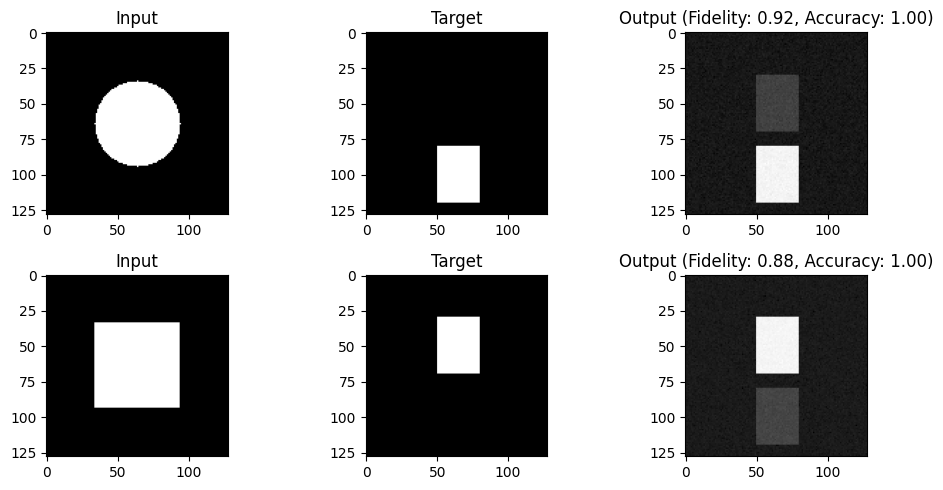

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions
def create_circle_image(size, radius):
    y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing="ij")
    center = size // 2
    mask = (x - center) ** 2 + (y - center) ** 2 <= radius ** 2
    return mask.float()

def create_square_image(size, side_length):
    img = torch.zeros((size, size))
    center = size // 2
    half_side = side_length // 2
    img[center - half_side:center + half_side, center - half_side:center + half_side] = 1.0
    return img

# Optical Layer: Phase Modulation
class PhaseLayer(nn.Module):
    def __init__(self, size):
        super(PhaseLayer, self).__init__()
        self.phase = nn.Parameter(torch.rand(size, size) * 2 * np.pi)

    def forward(self, field):
        return field * torch.exp(1j * self.phase)

# Propagation Function: Fresnel Diffraction
def fresnel_propagation(field, distance, wavelength, pixel_pitch):
    size = field.shape[-1]
    k = 2 * np.pi / wavelength
    fx = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    fy = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing="ij")
    H = torch.exp(-1j * (np.pi * wavelength * distance) * (FX**2 + FY**2))
    field_fft = torch.fft.fft2(field)
    field_propagated = torch.fft.ifft2(field_fft * H)
    return field_propagated

# Diffractive Neural Network
class DiffractiveNN(nn.Module):
    def __init__(self, num_layers, size, distance, wavelength, pixel_pitch):
        super(DiffractiveNN, self).__init__()
        self.layers = nn.ModuleList([PhaseLayer(size) for _ in range(num_layers)])
        self.distance = distance
        self.wavelength = wavelength
        self.pixel_pitch = pixel_pitch

    def forward(self, field):
        for layer in self.layers:
            field = layer(field)
            field = fresnel_propagation(field, self.distance, self.wavelength, self.pixel_pitch)
        return torch.abs(field) ** 2

# Detector Region Function
def create_region_image(size, region):
    image = torch.zeros((size, size))
    x0, x1, y0, y1 = region
    image[x0:x1, y0:y1] = 1
    return image

# Define Parameters
size = 128
circle = create_circle_image(size, radius=30)
square = create_square_image(size, side_length=60)
input_images = torch.stack([circle, square])

detector_regions = [[30, 70, 50, 80], [80, 120, 50, 80]]
target_images = torch.stack([create_region_image(size, detector_regions[1]), create_region_image(size, detector_regions[0])])

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_images = input_images.to(device)
target_images = target_images.to(device)

num_layers = 5
distance = 20e-3
wavelength = 633e-9
pixel_pitch = 8e-6

model = DiffractiveNN(num_layers, size, distance, wavelength, pixel_pitch).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 1500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(input_images)
    loss = criterion(outputs, target_images)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Compute Performance Metrics
def compute_fidelity(output, target):
    return torch.sum(output * target) / (torch.sqrt(torch.sum(output**2)) * torch.sqrt(torch.sum(target**2)))

def compute_accuracy(output, target):
    thresholded_output = (output > 0.5).float()
    return torch.mean((thresholded_output == target).float())

fidelities = [compute_fidelity(output_images[i], target_images[i]).item() for i in range(2)]
accuracies = [compute_accuracy(output_images[i], target_images[i]).item() for i in range(2)]
print(f"Fidelities: {fidelities}")
print(f"Accuracies: {accuracies}")

# Visualization
output_images = model(input_images).detach().cpu()
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(2, 3, i * 3 + 1)
    plt.title("Input")
    plt.imshow(input_images[i].cpu().numpy(), cmap="gray")
    plt.subplot(2, 3, i * 3 + 2)
    plt.title("Target")
    plt.imshow(target_images[i].cpu().numpy(), cmap="gray")
    plt.subplot(2, 3, i * 3 + 3)
    plt.title(f"Output (Fidelity: {fidelities[i]:.2f}, Accuracy: {accuracies[i]:.2f})")
    plt.imshow(output_images[i].numpy(), cmap="gray")
plt.tight_layout()
plt.show()


Epoch [50/1500], Loss: 0.0999
Epoch [100/1500], Loss: 0.0824
Epoch [150/1500], Loss: 0.0680
Epoch [200/1500], Loss: 0.0566
Epoch [250/1500], Loss: 0.0482
Epoch [300/1500], Loss: 0.0420
Epoch [350/1500], Loss: 0.0376
Epoch [400/1500], Loss: 0.0344
Epoch [450/1500], Loss: 0.0319
Epoch [500/1500], Loss: 0.0299
Epoch [550/1500], Loss: 0.0283
Epoch [600/1500], Loss: 0.0269
Epoch [650/1500], Loss: 0.0258
Epoch [700/1500], Loss: 0.0249
Epoch [750/1500], Loss: 0.0240
Epoch [800/1500], Loss: 0.0233
Epoch [850/1500], Loss: 0.0227
Epoch [900/1500], Loss: 0.0222
Epoch [950/1500], Loss: 0.0217
Epoch [1000/1500], Loss: 0.0213
Epoch [1050/1500], Loss: 0.0210
Epoch [1100/1500], Loss: 0.0207
Epoch [1150/1500], Loss: 0.0204
Epoch [1200/1500], Loss: 0.0201
Epoch [1250/1500], Loss: 0.0199
Epoch [1300/1500], Loss: 0.0197
Epoch [1350/1500], Loss: 0.0195
Epoch [1400/1500], Loss: 0.0193
Epoch [1450/1500], Loss: 0.0191
Epoch [1500/1500], Loss: 0.0190


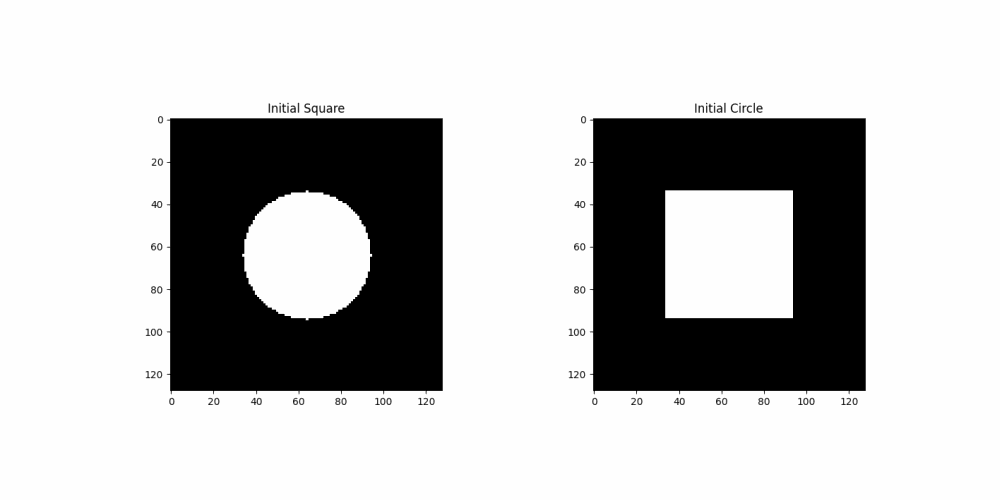

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from IPython.display import display, Image

# Utility Functions
def create_circle_image(size, radius):
    y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing="ij")
    center = size // 2
    mask = (x - center) ** 2 + (y - center) ** 2 <= radius ** 2
    return mask.float()

def create_square_image(size, side_length):
    img = torch.zeros((size, size))
    center = size // 2
    half_side = side_length // 2
    img[center - half_side:center + half_side, center - half_side:center + half_side] = 1.0
    return img

# Optical Layer: Phase Modulation
class PhaseLayer(nn.Module):
    def __init__(self, size):
        super(PhaseLayer, self).__init__()
        self.phase = nn.Parameter(torch.rand(size, size) * 2 * np.pi)

    def forward(self, field):
        return field * torch.exp(1j * self.phase)

# Propagation Function: Fresnel Diffraction
def fresnel_propagation(field, distance, wavelength, pixel_pitch):
    size = field.shape[-1]
    k = 2 * np.pi / wavelength
    fx = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    fy = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing="ij")
    H = torch.exp(-1j * (np.pi * wavelength * distance) * (FX**2 + FY**2))
    field_fft = torch.fft.fft2(field)
    field_propagated = torch.fft.ifft2(field_fft * H)
    return field_propagated

# Diffractive Neural Network
class DiffractiveNN(nn.Module):
    def __init__(self, num_layers, size, distance, wavelength, pixel_pitch):
        super(DiffractiveNN, self).__init__()
        self.layers = nn.ModuleList([PhaseLayer(size) for _ in range(num_layers)])
        self.distance = distance
        self.wavelength = wavelength
        self.pixel_pitch = pixel_pitch

    def forward(self, field):
        for layer in self.layers:
            field = layer(field)
            field = fresnel_propagation(field, self.distance, self.wavelength, self.pixel_pitch)
        return torch.abs(field) ** 2

# Detector Region Function
def create_region_image(size, region):
    image = torch.zeros((size, size))
    x0, x1, y0, y1 = region
    image[x0:x1, y0:y1] = 1
    return image

# Define Parameters
size = 128
circle = create_circle_image(size, radius=30)
square = create_square_image(size, side_length=60)
input_images = torch.stack([circle, square])

detector_regions = [[30, 70, 50, 80], [80, 120, 50, 80]]
target_images = torch.stack([create_region_image(size, detector_regions[1]), create_region_image(size, detector_regions[0])])

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_images = input_images.to(device)
target_images = target_images.to(device)

num_layers = 5
distance = 20e-3
wavelength = 633e-9
pixel_pitch = 8e-6

model = DiffractiveNN(num_layers, size, distance, wavelength, pixel_pitch).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 1500
frames = {"square": [], "circle": []}
temp_dir = "training_frames"
os.makedirs(temp_dir, exist_ok=True)

# Save initial images
for i, shape in enumerate(["square", "circle"]):
    plt.figure(figsize=(5, 5))
    plt.imshow(input_images[i].cpu().numpy(), cmap="gray")
    plt.title(f"Initial {shape.capitalize()}")
    frame_path = os.path.join(temp_dir, f"{shape}_epoch_0.png")
    plt.savefig(frame_path)
    plt.close()
    frames[shape].append(frame_path)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(input_images)
    loss = criterion(outputs, target_images)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0 or epoch == 0:
        output_images = outputs.detach().cpu().numpy()
        for i, shape in enumerate(["square", "circle"]):
            plt.figure(figsize=(5, 5))
            plt.imshow(output_images[i], cmap="gray")
            plt.title(f"Epoch {epoch + 1}")
            frame_path = os.path.join(temp_dir, f"{shape}_epoch_{epoch + 1}.png")
            plt.savefig(frame_path)
            plt.close()
            frames[shape].append(frame_path)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Create and Display GIFs
combined_gif_path = "classification_process.gif"
images = []
for i in range(len(frames["square"])):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for j, shape in enumerate(["square", "circle"]):
        img = plt.imread(frames[shape][i])
        axes[j].imshow(img, cmap="gray")
        axes[j].axis("off")
    frame_path = os.path.join(temp_dir, f"combined_epoch_{i * 50}.png")
    plt.savefig(frame_path)
    plt.close()
    images.append(imageio.imread(frame_path))

imageio.mimsave(combined_gif_path, images, fps=5)
display(Image(filename=combined_gif_path))


In [13]:
import numpy as np

class OpticalLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros((1, output_dim))
    
    def forward(self, inputs):
        return np.dot(inputs, self.weights) + self.biases
    
    def backward(self, d_out, inputs, learning_rate):
        d_weights = np.dot(inputs.T, d_out)
        d_biases = np.sum(d_out, axis=0, keepdims=True)
        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_biases
        return np.dot(d_out, self.weights.T)

class OpticalNeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        self.num_layers = num_layers
        self.layers = []
        
        if num_layers == 2:
            self.layers.append(OpticalLayer(input_dim, hidden_dim))
            self.layers.append(OpticalLayer(hidden_dim, output_dim))
        elif num_layers == 3:
            self.layers.append(OpticalLayer(input_dim, hidden_dim))
            self.layers.append(OpticalLayer(hidden_dim, hidden_dim))
            self.layers.append(OpticalLayer(hidden_dim, output_dim))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, d_loss, inputs, learning_rate):
        for i in range(len(self.layers) - 1, -1, -1):
            d_loss = self.layers[i].backward(d_loss, inputs, learning_rate)

class AdamOptimizer:
    def __init__(self, layers, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.layers = layers
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(layer.weights) for layer in layers]
        self.v = [np.zeros_like(layer.weights) for layer in layers]
        self.t = 0
    
    def update(self, gradients):
        self.t += 1
        for i, layer in enumerate(self.layers):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gradients[i] ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            layer.weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

# Example Usage
np.random.seed(42)
nn_2_layer = OpticalNeuralNetwork(input_dim=4, hidden_dim=5, output_dim=3, num_layers=2)
nn_3_layer = OpticalNeuralNetwork(input_dim=4, hidden_dim=5, output_dim=3, num_layers=3)

data = np.random.randn(10, 4)
output_2_layer = nn_2_layer.forward(data)
output_3_layer = nn_3_layer.forward(data)

print("Output (2-layer):", output_2_layer)
print("Output (3-layer):", output_3_layer)


Output (2-layer): [[-5.30488959e-05  1.34530388e-04 -4.89018926e-04]
 [ 4.49210348e-04 -1.15798964e-04  3.77072737e-04]
 [ 1.88640662e-04  7.23556006e-04 -9.79487930e-04]
 [-1.96735860e-04 -5.98695349e-04  6.70068637e-04]
 [ 4.08743850e-05  7.85386382e-04 -1.22780773e-03]
 [ 3.20062736e-05 -8.72060818e-05  3.13538243e-04]
 [-2.34622469e-04 -1.23604261e-05  1.38022002e-04]
 [-1.50430158e-04  4.86486177e-04 -1.18085002e-03]
 [-1.16912129e-04 -5.94173929e-04  6.19805549e-04]
 [ 3.17590419e-04 -1.57394104e-05  1.39264570e-04]]
Output (3-layer): [[ 6.00890317e-06  3.74366163e-06  1.25156044e-05]
 [ 3.74707168e-06  1.94745951e-06  5.98096880e-06]
 [ 7.91027377e-06  3.16493166e-06  1.39555691e-05]
 [-4.95162820e-06 -1.62036748e-06 -8.94411658e-06]
 [ 3.62933882e-06 -8.99344592e-07 -4.33393262e-06]
 [-1.14156566e-06  1.24748848e-07  2.98214535e-06]
 [-4.57409719e-06 -1.86643495e-06 -3.27660202e-06]
 [ 6.33232183e-06  2.17841755e-06  4.68335431e-06]
 [-1.31916906e-06  9.23065801e-07  4.43443902

Epoch [50/1500], Loss: 0.0998
Epoch [100/1500], Loss: 0.0821
Epoch [150/1500], Loss: 0.0676
Epoch [200/1500], Loss: 0.0561
Epoch [250/1500], Loss: 0.0477
Epoch [300/1500], Loss: 0.0417
Epoch [350/1500], Loss: 0.0374
Epoch [400/1500], Loss: 0.0342
Epoch [450/1500], Loss: 0.0317
Epoch [500/1500], Loss: 0.0298
Epoch [550/1500], Loss: 0.0282
Epoch [600/1500], Loss: 0.0268
Epoch [650/1500], Loss: 0.0257
Epoch [700/1500], Loss: 0.0248
Epoch [750/1500], Loss: 0.0240
Epoch [800/1500], Loss: 0.0233
Epoch [850/1500], Loss: 0.0227
Epoch [900/1500], Loss: 0.0222
Epoch [950/1500], Loss: 0.0217
Epoch [1000/1500], Loss: 0.0213
Epoch [1050/1500], Loss: 0.0210
Epoch [1100/1500], Loss: 0.0206
Epoch [1150/1500], Loss: 0.0203
Epoch [1200/1500], Loss: 0.0201
Epoch [1250/1500], Loss: 0.0199
Epoch [1300/1500], Loss: 0.0196
Epoch [1350/1500], Loss: 0.0195
Epoch [1400/1500], Loss: 0.0193
Epoch [1450/1500], Loss: 0.0191
Epoch [1500/1500], Loss: 0.0190
Fidelities: [0.9151710271835327, 0.8805235028266907]
Accurac

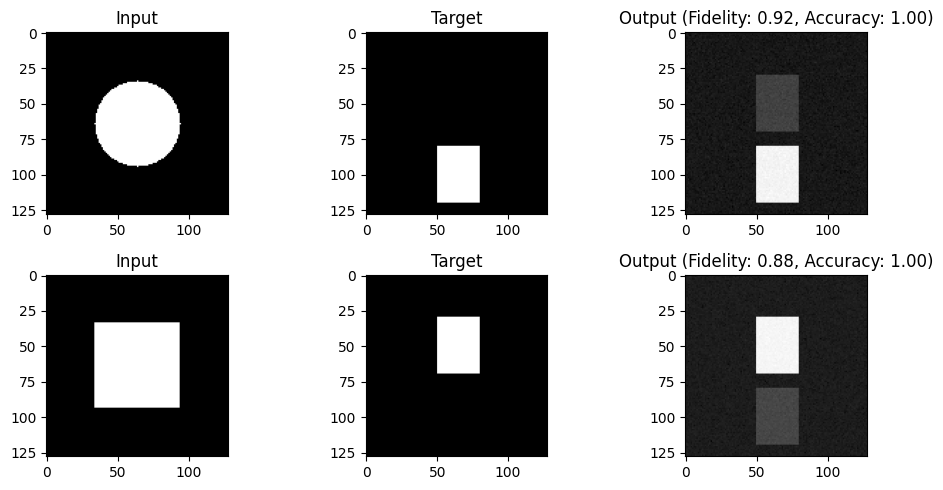

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions
def create_meshgrid(size):
    y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing="ij")
    return x, y

def create_circle_image(size, radius):
    x, y = create_meshgrid(size)
    center = size // 2
    mask = (x - center) ** 2 + (y - center) ** 2 <= radius ** 2
    return mask.float()

def create_square_image(size, side_length):
    img = torch.zeros((size, size))
    center = size // 2
    half_side = side_length // 2
    img[center - half_side:center + half_side, center - half_side:center + half_side] = 1.0
    return img

# Optical Layer: Trainable Phase Modulation
class PhaseLayer(nn.Module):
    def __init__(self, size):
        super(PhaseLayer, self).__init__()
        self.phase = nn.Parameter(torch.rand(size, size) * 2 * np.pi)  # Trainable pixel phase values

    def forward(self, field):
        return field * torch.exp(1j * self.phase)

# Propagation Function: Fresnel Diffraction
def fresnel_propagation(field, distance, wavelength, pixel_pitch):
    size = field.shape[-1]
    k = 2 * np.pi / wavelength
    fx = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    fy = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing="ij")
    H = torch.exp(-1j * (np.pi * wavelength * distance) * (FX**2 + FY**2))
    field_fft = torch.fft.fft2(field)
    field_propagated = torch.fft.ifft2(field_fft * H)
    return field_propagated

# Diffractive Neural Network
class DiffractiveNN(nn.Module):
    def __init__(self, num_layers, size, distance, wavelength, pixel_pitch):
        super(DiffractiveNN, self).__init__()
        self.layers = nn.ModuleList([PhaseLayer(size) for _ in range(num_layers)])
        self.distance = distance
        self.wavelength = wavelength
        self.pixel_pitch = pixel_pitch

    def forward(self, field):
        for layer in self.layers:
            field = layer(field)
            field = fresnel_propagation(field, self.distance, self.wavelength, self.pixel_pitch)
        return torch.abs(field) ** 2

# Detector Region Function
def create_region_image(size, region):
    image = torch.zeros((size, size))
    x0, x1, y0, y1 = region
    image[x0:x1, y0:y1] = 1
    return image

# Define Parameters
size = 128
circle = create_circle_image(size, radius=30)
square = create_square_image(size, side_length=60)
input_images = torch.stack([circle, square])

detector_regions = [[30, 70, 50, 80], [80, 120, 50, 80]]
target_images = torch.stack([create_region_image(size, detector_regions[1]), create_region_image(size, detector_regions[0])])

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_images = input_images.to(device)
target_images = target_images.to(device)

num_layers = 5
distance = 20e-3
wavelength = 633e-9
pixel_pitch = 8e-6

model = DiffractiveNN(num_layers, size, distance, wavelength, pixel_pitch).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 1500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(input_images)
    loss = criterion(outputs, target_images)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Compute Performance Metrics
def compute_fidelity(output, target):
    return torch.sum(output * target) / (torch.sqrt(torch.sum(output**2)) * torch.sqrt(torch.sum(target**2)))

def compute_accuracy(output, target):
    thresholded_output = (output > 0.5).float()
    return torch.mean((thresholded_output == target).float())

output_images = model(input_images).detach().cpu()
fidelities = [compute_fidelity(output_images[i], target_images[i]).item() for i in range(2)]
accuracies = [compute_accuracy(output_images[i], target_images[i]).item() for i in range(2)]
print(f"Fidelities: {fidelities}")
print(f"Accuracies: {accuracies}")

# Visualization
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(2, 3, i * 3 + 1)
    plt.title("Input")
    plt.imshow(input_images[i].cpu().numpy(), cmap="gray")
    plt.subplot(2, 3, i * 3 + 2)
    plt.title("Target")
    plt.imshow(target_images[i].cpu().numpy(), cmap="gray")
    plt.subplot(2, 3, i * 3 + 3)
    plt.title(f"Output (Fidelity: {fidelities[i]:.2f}, Accuracy: {accuracies[i]:.2f})")
    plt.imshow(output_images[i].numpy(), cmap="gray")
plt.tight_layout()
plt.show()


Epoch [50/1500], Loss: 0.1002
Epoch [100/1500], Loss: 0.0824
Epoch [150/1500], Loss: 0.0679
Epoch [200/1500], Loss: 0.0564
Epoch [250/1500], Loss: 0.0480
Epoch [300/1500], Loss: 0.0419
Epoch [350/1500], Loss: 0.0376
Epoch [400/1500], Loss: 0.0343
Epoch [450/1500], Loss: 0.0318
Epoch [500/1500], Loss: 0.0298
Epoch [550/1500], Loss: 0.0282
Epoch [600/1500], Loss: 0.0269
Epoch [650/1500], Loss: 0.0258
Epoch [700/1500], Loss: 0.0248
Epoch [750/1500], Loss: 0.0240
Epoch [800/1500], Loss: 0.0233
Epoch [850/1500], Loss: 0.0227
Epoch [900/1500], Loss: 0.0222
Epoch [950/1500], Loss: 0.0217
Epoch [1000/1500], Loss: 0.0213
Epoch [1050/1500], Loss: 0.0209
Epoch [1100/1500], Loss: 0.0206
Epoch [1150/1500], Loss: 0.0203
Epoch [1200/1500], Loss: 0.0201
Epoch [1250/1500], Loss: 0.0198
Epoch [1300/1500], Loss: 0.0196
Epoch [1350/1500], Loss: 0.0194
Epoch [1400/1500], Loss: 0.0193
Epoch [1450/1500], Loss: 0.0191
Epoch [1500/1500], Loss: 0.0190
Fidelities: [0.9152557849884033, 0.880587100982666]
Accuraci

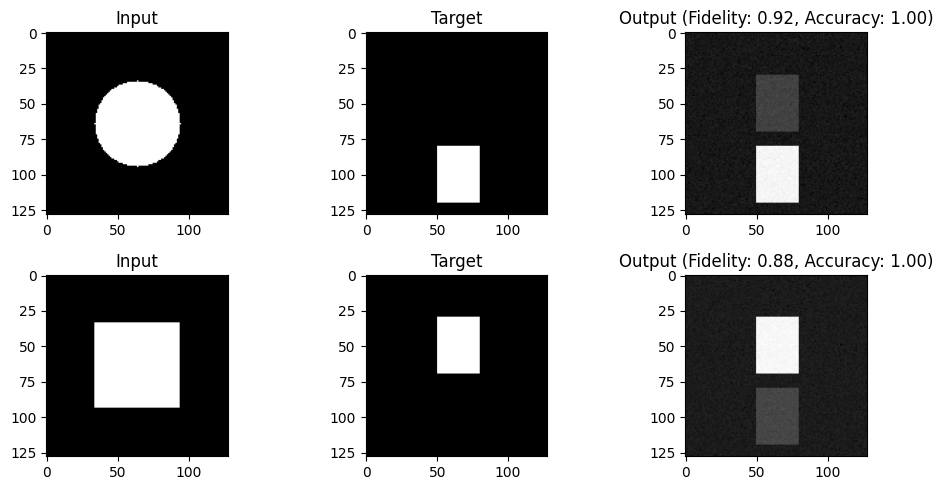

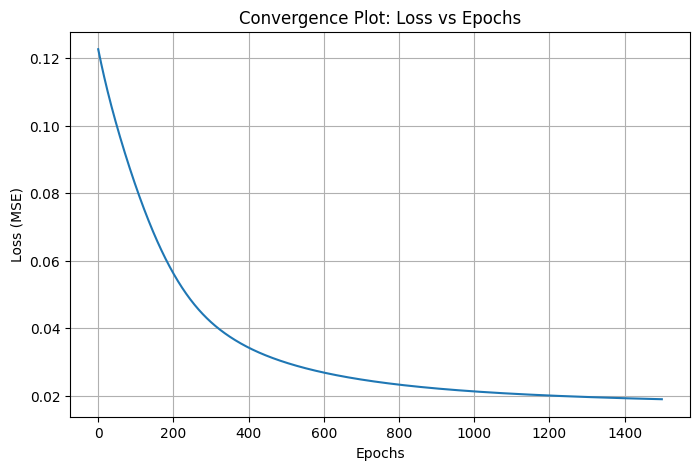

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Utility Functions
def create_meshgrid(size):
    """Creates a meshgrid for coordinate calculations."""
    y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing="ij")
    return x, y

def create_circle_image(size, radius):
    """Creates a binary image of a circle."""
    x, y = create_meshgrid(size)
    center = size // 2
    mask = (x - center) ** 2 + (y - center) ** 2 <= radius ** 2
    return mask.float()

def create_square_image(size, side_length):
    """Creates a binary image of a square."""
    img = torch.zeros((size, size))
    center = size // 2
    half_side = side_length // 2
    img[center - half_side:center + half_side, center - half_side:center + half_side] = 1.0
    return img

# Optical Layer: Trainable Phase Modulation
class PhaseLayer(nn.Module):
    def __init__(self, size):
        super(PhaseLayer, self).__init__()
        # Initialize phase values randomly between 0 and 2*pi
        self.phase = nn.Parameter(torch.rand(size, size) * 2 * np.pi)

    def forward(self, field):
        """Applies phase modulation to the input field."""
        return field * torch.exp(1j * self.phase)

# Propagation Function: Fresnel Diffraction
def fresnel_propagation(field, distance, wavelength, pixel_pitch):
    """Computes Fresnel diffraction for light propagation."""
    size = field.shape[-1]
    k = 2 * np.pi / wavelength  # Wave number
    fx = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    fy = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing="ij")
    H = torch.exp(-1j * (np.pi * wavelength * distance) * (FX**2 + FY**2))
    field_fft = torch.fft.fft2(field)
    field_propagated = torch.fft.ifft2(field_fft * H)
    return field_propagated

# Diffractive Neural Network Model
class DiffractiveNN(nn.Module):
    def __init__(self, num_layers, size, distance, wavelength, pixel_pitch):
        super(DiffractiveNN, self).__init__()
        self.layers = nn.ModuleList([PhaseLayer(size) for _ in range(num_layers)])
        self.distance = distance
        self.wavelength = wavelength
        self.pixel_pitch = pixel_pitch

    def forward(self, field):
        """Passes the input field through multiple phase layers and propagates it."""
        for layer in self.layers:
            field = layer(field)
            field = fresnel_propagation(field, self.distance, self.wavelength, self.pixel_pitch)
        return torch.abs(field) ** 2  # Convert to intensity

# Detector Region Function
def create_region_image(size, region):
    """Creates a binary image for a specified detector region."""
    image = torch.zeros((size, size))
    x0, x1, y0, y1 = region
    image[x0:x1, y0:y1] = 1
    return image

# Define Parameters
size = 128  # Image size
circle = create_circle_image(size, radius=30)
square = create_square_image(size, side_length=60)
input_images = torch.stack([circle, square])

detector_regions = [[30, 70, 50, 80], [80, 120, 50, 80]]
target_images = torch.stack([create_region_image(size, detector_regions[1]), create_region_image(size, detector_regions[0])])

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_images = input_images.to(device)
target_images = target_images.to(device)

# Model Hyperparameters
num_layers = 5
distance = 20e-3
wavelength = 633e-9
pixel_pitch = 8e-6

model = DiffractiveNN(num_layers, size, distance, wavelength, pixel_pitch).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 1500
losses = []  # Store loss values for convergence plot

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(input_images)
    loss = criterion(outputs, target_images)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Compute Performance Metrics
def compute_fidelity(output, target):
    """Computes fidelity between the output and target."""
    return torch.sum(output * target) / (torch.sqrt(torch.sum(output**2)) * torch.sqrt(torch.sum(target**2)))

def compute_accuracy(output, target):
    """Computes accuracy by thresholding the output."""
    thresholded_output = (output > 0.5).float()
    return torch.mean((thresholded_output == target).float())

output_images = model(input_images).detach().cpu()
fidelities = [compute_fidelity(output_images[i], target_images[i]).item() for i in range(2)]
accuracies = [compute_accuracy(output_images[i], target_images[i]).item() for i in range(2)]
print(f"Fidelities: {fidelities}")
print(f"Accuracies: {accuracies}")

# Visualization
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(2, 3, i * 3 + 1)
    plt.title("Input")
    plt.imshow(input_images[i].cpu().numpy(), cmap="gray")
    
    plt.subplot(2, 3, i * 3 + 2)
    plt.title("Target")
    plt.imshow(target_images[i].cpu().numpy(), cmap="gray")
    
    plt.subplot(2, 3, i * 3 + 3)
    plt.title(f"Output (Fidelity: {fidelities[i]:.2f}, Accuracy: {accuracies[i]:.2f})")
    plt.imshow(output_images[i].numpy(), cmap="gray")

plt.tight_layout()
plt.show()

# Convergence Plot
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Convergence Plot: Loss vs Epochs")
plt.grid(True)
plt.show()

